In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [4]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [5]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [6]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [7]:
class RNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)

In [8]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [9]:
@d2l.add_to_class(RNNLMScratch)  #@save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

In [10]:
@d2l.add_to_class(RNNLMScratch)  #@save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)

@d2l.add_to_class(RNNLMScratch)  #@save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [11]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

In [12]:
@d2l.add_to_class(d2l.Trainer)  #@save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

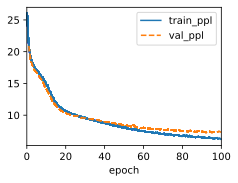

In [13]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
print()

In [15]:
@d2l.add_to_class(RNNLMScratch)  #@save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [16]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in the the the the '